In [ ]:
!pip install sentence_transformers neo4j
!pip install torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
#!pip install tensorflow_ranking

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.4/188.4 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=894492004e1aa11c7d71bc76db065b8a96fd4e4f413f5f7fb7a70f1db48dcc07
  Stored in directory: /root/.cache/pip/wh

In [ ]:
#!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
#!python.exe -m pip install --upgrade pip
#!pip install torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html --user
#!pip uninstall torch-sparse
import torch_sparse
print(torch_sparse.__version__)

0.6.17+pt20cpu


In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.nn import Linear
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from typing import Dict, Tuple
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero

from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected, RandomLinkSplit, RandomNodeSplit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


First, we can create a data object of type torch_geometric.data.HeteroData, for which we define node feature tensors, edge index tensors and edge feature tensors individually for each type:
Node or edge tensors will be automatically created upon first access and indexed by string keys. Node types are identified by a single string while edge types are identified by using a triplet (source_node_type, edge_type, destination_node_type) of strings: the edge type identifier and the two node types between which the edge type can exist. As such, the data object allows different feature dimensionalities for each type.

In [ ]:
from neo4j import GraphDatabase

url= 'bolt://localhost:7687'
user = 'neo4j'
password = '*********'

driver = GraphDatabase.driver(url, auth=(user, password))

def fetch_data(query, params={}):
  with driver.session() as session:
    result = session.run(query, params)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Export Neo4j Graph and construct a heterogeneous pyG graph

In [ ]:
def load_node(cypher, index_col, encoders=None, **kwargs):
    # Execute the cypher query and retrieve data from Neo4j
    df = fetch_data(cypher)
    df.set_index(index_col, inplace=True)
    # Define node mapping
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    # Define node features
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [ ]:
def load_edge(cypher, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  encoders=None, **kwargs):
    # Execute the cypher query and retrieve data from Neo4j
    df = fetch_data(cypher)
    # Define edge index
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    # Define edge features
    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

## Defining the feature encoders

In [ ]:
class SequenceEncoder(object):
    # The 'SequenceEncoder' encodes raw column strings into embeddings.
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        df = df.fillna('')
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()

In [ ]:
class IdentityEncoder(object):
    # The 'IdentityEncoder' takes the raw column values and converts them to
    # PyTorch tensors.
    def __init__(self, dtype=None, is_list=False):
        self.dtype = dtype
        self.is_list = is_list

    def __call__(self, df):
        if self.is_list:
            return torch.stack([torch.tensor(el) for el in df.values])
        tensor=torch.from_numpy(df.values).to(self.dtype)
        tensor = tensor.unsqueeze(1)  # Add second dimension with size 1
        return tensor

## Fetch the data from Neo4j and construct user mappings and features that will be used as input to the pyG heterogeneous graph.

### Entire Network

In [ ]:
# Nodes Query
encoder = {
    #'CompanyId' : IdentityEncoder(),
    'type': SequenceEncoder(model_name='all-MiniLM-L6-v2'),
    'company': IdentityEncoder(),
   'country': SequenceEncoder(model_name='all-MiniLM-L6-v2'),
    'sector': SequenceEncoder(model_name='all-MiniLM-L6-v2'),
    'industry': SequenceEncoder(model_name='all-MiniLM-L6-v2'),
    'nace': SequenceEncoder(model_name='all-MiniLM-L6-v2')
}
user_query = """
MATCH (n:Company)--(t)
WHERE t:CompanyType OR t:Country OR t:Sector OR t:Industry OR t:Nace
RETURN distinct n.id as CompanyId, id(n) as company,
  COLLECT(DISTINCT CASE WHEN t:CompanyType THEN t.name ELSE NULL END)[0] AS type,
  COLLECT(DISTINCT CASE WHEN t:Country THEN t.id ELSE NULL END)[0] AS country,
  COLLECT(DISTINCT CASE WHEN t:Sector THEN t.name ELSE NULL END)[0] AS sector,
  COLLECT(DISTINCT CASE WHEN t:Industry THEN t.name ELSE NULL END)[0] AS industry,
  COLLECT(DISTINCT CASE WHEN t:Nace THEN t.name ELSE NULL END)[0] AS nace
"""

company_x, company_mapping = load_node(user_query, index_col='CompanyId', encoders=encoder)

In [ ]:
edge_query = """
MATCH (u:Company)-[r:SUPPLIES]->(m:Company)
RETURN u.id AS Company1Id, m.id AS Company2Id, r.weight AS weight
"""
# didn't include revenue, and start date
supplies_index, supplies_label = load_edge(
    edge_query,
    src_index_col='Company1Id',
    src_mapping=company_mapping,
    dst_index_col='Company2Id',
    dst_mapping=company_mapping,
    encoders={'weight': IdentityEncoder(dtype=torch.long,is_list=True)},
)

In [ ]:
edge_query = """
MATCH (u:Company)-[r:PARTNERS]->(m:Company)
RETURN u.id AS Company1Id, m.id AS Company2Id, r.start_date AS start_date
"""
# didn't include start date
partners_index, partners_label = load_edge(
    edge_query,
    src_index_col='Company1Id',
    src_mapping=company_mapping,
    dst_index_col='Company2Id',
    dst_mapping=company_mapping
    #encoders={'start_date': IdentityEncoder(dtype=torch.long)},
)

In [ ]:
edge_query = """
MATCH (u:Company)-[r:COMPETES]->(m:Company)
RETURN u.id AS Company1Id, m.id AS Company2Id, r.start_date AS start_date
"""
# didn't include start date
competes_index, competes_label = load_edge(
    edge_query,
    src_index_col='Company1Id',
    src_mapping=company_mapping,
    dst_index_col='Company2Id',
    dst_mapping=company_mapping
    #encoders={'start_date': IdentityEncoder(dtype=torch.long)},
)

In [ ]:
edge_query = """
MATCH (u:Company)-[r:ULTIMATE_PARENT_OF]->(m:Company)
RETURN u.id AS Company1Id, m.id AS Company2Id, r.start_date AS start_date
"""
parent_index, parent_label = load_edge(
    edge_query,
    src_index_col='Company1Id',
    src_mapping=company_mapping,
    dst_index_col='Company2Id',
    dst_mapping=company_mapping
    #encoders={'start_date': IdentityEncoder(dtype=torch.long)},
)

### Sectorising

In [ ]:
## Nodes Query: insert sectors name into i.name='Sector_name'
encoder = {
    #'CompanyId' : IdentityEncoder(),
    'type': SequenceEncoder(model_name='all-MiniLM-L6-v2'),
    'company': IdentityEncoder(),
   'country': SequenceEncoder(model_name='all-MiniLM-L6-v2'),
    'sector': SequenceEncoder(model_name='all-MiniLM-L6-v2'),
    'industry': SequenceEncoder(model_name='all-MiniLM-L6-v2'),
    'nace': SequenceEncoder(model_name='all-MiniLM-L6-v2')
}
user_query = """
MATCH (n:Company)--(i:Sector) where i.name='Technology Services' or i.name='Electronic Technology' with n
MATCH (n)--(t)
WHERE t:CompanyType OR t:Country OR t:Sector OR t:Industry OR t:Nace
RETURN distinct n.id as CompanyId, id(n) as company,
  COLLECT(DISTINCT CASE WHEN t:CompanyType THEN t.name ELSE NULL END)[0] AS type,
  COLLECT(DISTINCT CASE WHEN t:Country THEN t.id ELSE NULL END)[0] AS country,
  COLLECT(DISTINCT CASE WHEN t:Sector THEN t.name ELSE NULL END)[0] AS sector,
  COLLECT(DISTINCT CASE WHEN t:Industry THEN t.name ELSE NULL END)[0] AS industry,
  COLLECT(DISTINCT CASE WHEN t:Nace THEN t.name ELSE NULL END)[0] AS nace
"""

company_x, company_mapping = load_node(user_query, index_col='CompanyId', encoders=encoder)

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

In [ ]:
## Edge Query: insert sectors name into i.name='Sector_name'
edge_query = """
MATCH (u:Company)--(i:Sector) where i.name='Technology Services' or i.name='Electronic Technology'   with u
MATCH (m:Company)--(j:Sector) where j.name='Technology Services' or j.name='Electronic Technology'  with u,m
MATCH (u)-[r:SUPPLIES]->(m)
RETURN u.id AS Company1Id, m.id AS Company2Id, r.weight AS weight
"""
# didn't include revenue, and start date
supplies_index, supplies_label = load_edge(
    edge_query,
    src_index_col='Company1Id',
    src_mapping=company_mapping,
    dst_index_col='Company2Id',
    dst_mapping=company_mapping,
    encoders={'weight': IdentityEncoder(dtype=torch.long,is_list=True)},
)

In [ ]:
edge_query = """
MATCH (u:Company)--(i:Sector) where i.name='Technology Services' or i.name='Electronic Technology'   with u
MATCH (m:Company)--(j:Sector) where j.name='Technology Services' or j.name='Electronic Technology'  with u,m
MATCH (u)-[r:PARTNERS]->(m)
RETURN u.id AS Company1Id, m.id AS Company2Id, r.start_date AS start_date
"""
# didn't include start date
partners_index, partners_label = load_edge(
    edge_query,
    src_index_col='Company1Id',
    src_mapping=company_mapping,
    dst_index_col='Company2Id',
    dst_mapping=company_mapping
    #encoders={'start_date': IdentityEncoder(dtype=torch.long)},
)

In [ ]:
edge_query = """
MATCH (u:Company)--(i:Sector) where i.name='Technology Services' or i.name='Electronic Technology'   with u
MATCH (m:Company)--(j:Sector) where j.name='Technology Services' or j.name='Electronic Technology'  with u,m
MATCH (u)-[r:COMPETES]->(m)
RETURN u.id AS Company1Id, m.id AS Company2Id, r.start_date AS start_date
"""
# didn't include start date
competes_index, competes_label = load_edge(
    edge_query,
    src_index_col='Company1Id',
    src_mapping=company_mapping,
    dst_index_col='Company2Id',
    dst_mapping=company_mapping
    #encoders={'start_date': IdentityEncoder(dtype=torch.long)},
)

In [ ]:
edge_query = """
MATCH (u:Company)--(i:Sector) where i.name='Technology Services' or i.name='Electronic Technology'   with u
MATCH (m:Company)--(j:Sector) where j.name='Technology Services' or j.name='Electronic Technology' with u,m
MATCH (u)-[r:ULTIMATE_PARENT_OF]->(m)
RETURN u.id AS Company1Id, m.id AS Company2Id, r.start_date AS start_date
"""
parent_index, parent_label = load_edge(
    edge_query,
    src_index_col='Company1Id',
    src_mapping=company_mapping,
    dst_index_col='Company2Id',
    dst_mapping=company_mapping
    #encoders={'start_date': IdentityEncoder(dtype=torch.long)},
)

## Build a heterogeneous pyG graph

In [ ]:
data = HeteroData()
# Add nodes for message passing:  # They do not have any features.
data['Company'].num_nodes = len(company_mapping)
#data['Company'].x = torch.eye(data['Company'].num_nodes, device=device)
data['Company'].x = company_x #--> Add user node features
#data['Country'].num_nodes = len(Country_mapping)
#data['Country'].x = Country_x
#data['CompanyType'].num_nodes = len(CompanyType_mapping)
#data['Sector'].num_nodes = len(Sector_mapping)
#data['Sector'].x = Sector_x
#data['Industry'].num_nodes = len(Industry_mapping)
#data['Industry'].x = Industry_x
#data['Nace'].num_nodes = len(Nace_mapping)
#data['Nace'].x = Nace_x
# Add relations between nodes
data['Company', 'SUPPLIES', 'Company'].edge_index = supplies_index
#data['Company', 'SUPPLIES', 'Company'].edge_label = supplies_label

data['Company', 'PARTNERS', 'Company'].edge_index = partners_index
#data['Company', 'PARTNERS', 'Company'].edge_label = partners_label

data['Company', 'COMPETES', 'Company'].edge_index = competes_index
#data['Company', 'COMPETES', 'Company'].edge_label = competes_label

data['Company', 'ULTIMATE_PARENT_OF', 'Company'].edge_index = parent_index
#data['Company', 'ULTIMATE_PARENT_OF', 'Company'].edge_label = parent_label

#data['Company', 'BELONGS_TO', 'Sector'].edge_index = belongs_index
#data['Company', 'BELONGS_TO', 'Sector'].edge_label = belongs_label

#data['Company', 'BELONGS_TO', 'Industry'].edge_index = belongs2_index
#data['Company', 'BELONGS_TO', 'Industry'].edge_label = belongs2_label

#data['Company', 'IS_A', 'CompanyType'].edge_index = is_index
#data['Company', 'IS_A', 'CompanyType'].edge_label = is_label

#data['Company', 'LOCATED_IN', 'Country'].edge_index = located_index
#data['Company', 'LOCATED_IN', 'Country'].edge_label = located_label

#data['Company', 'SHIPS_TO', 'Country'].edge_index = ships_index
#data['Company', 'SHIPS_TO', 'Country'].edge_label = ships_label

#data['Company', 'PERFORMS', 'Nace'].edge_index = nace_index
#data['Company', 'SHIPS_TO', 'Country'].edge_label = ships_label

data.to(device, non_blocking=True)

HeteroData(
  Company={
    num_nodes=34615,
    x=[34615, 1921]
  },
  (Company, SUPPLIES, Company)={ edge_index=[2, 22986] },
  (Company, PARTNERS, Company)={ edge_index=[2, 11053] },
  (Company, COMPETES, Company)={ edge_index=[2, 10954] },
  (Company, ULTIMATE_PARENT_OF, Company)={ edge_index=[2, 5622] }
)

# Save and Load Graph HeteroData Object

In [ ]:
#Save
#torch.save(data, 'graph')

In [ ]:
#If Google Collab being used
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Import
#for Network 1: /graph_1
#for Network 2: /graph_ElectronicTechnology
#for Network 3: /graph_2
data=torch.load('/content/drive/MyDrive/THESIS/graph_ElectronicTechnology').to(device)

In [ ]:
data

HeteroData(
  Company={
    num_nodes=11669,
    x=[11669, 1921]
  },
  (Company, SUPPLIES, Company)={
    edge_index=[2, 8090],
    edge_attr=[8090]
  },
  (Company, PARTNERS, Company)={ edge_index=[2, 2663] },
  (Company, COMPETES, Company)={ edge_index=[2, 4795] },
  (Company, ULTIMATE_PARENT_OF, Company)={ edge_index=[2, 1510] }
)

# Train/test data split

In [ ]:
edge_types=data.edge_types[0:4]
edge_types

[('Company', 'SUPPLIES', 'Company'),
 ('Company', 'PARTNERS', 'Company'),
 ('Company', 'COMPETES', 'Company'),
 ('Company', 'ULTIMATE_PARENT_OF', 'Company')]

In [ ]:
# 1. Add a reverse ('movie', 'rev_rates', 'user') relation for message passing.
data_und = ToUndirected(merge=False)(data)
data_und

HeteroData(
  Company={
    num_nodes=11669,
    x=[11669, 1921]
  },
  (Company, SUPPLIES, Company)={
    edge_index=[2, 8090],
    edge_attr=[8090]
  },
  (Company, PARTNERS, Company)={ edge_index=[2, 2663] },
  (Company, COMPETES, Company)={ edge_index=[2, 4795] },
  (Company, ULTIMATE_PARENT_OF, Company)={ edge_index=[2, 1510] },
  (Company, rev_SUPPLIES, Company)={
    edge_index=[2, 8090],
    edge_attr=[8090]
  },
  (Company, rev_PARTNERS, Company)={ edge_index=[2, 2663] },
  (Company, rev_COMPETES, Company)={ edge_index=[2, 4795] },
  (Company, rev_ULTIMATE_PARENT_OF, Company)={ edge_index=[2, 1510] }
)

In [ ]:
reverse_edge_types = [(x[2], "{}_{}".format('rev', x[1]), x[0]) for x in edge_types]
reverse_edge_types

[('Company', 'rev_SUPPLIES', 'Company'),
 ('Company', 'rev_PARTNERS', 'Company'),
 ('Company', 'rev_COMPETES', 'Company'),
 ('Company', 'rev_ULTIMATE_PARENT_OF', 'Company')]

In [ ]:
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit

## designed for transductive learning https://zqfang.github.io/2021-08-12-graph-linkpredict/#inductive-link-prediction-split
tfs = RandomLinkSplit(is_undirected=True,
                      num_val=0.1,
                      num_test=0.2,
                      add_negative_train_samples=True,
                      neg_sampling_ratio=1.0,
                      #key = "edge_label", # supervision label
                      disjoint_train_ratio=0,# disjoint mode if > 0
                      edge_types=edge_types, # for heteroData
                      rev_edge_types=reverse_edge_types, # for heteroData
                      )
train_data, val_data, test_data = tfs(data_und)
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:


#After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
print(train_data)
print(val_data)
print(test_data)


HeteroData(
  Company={
    num_nodes=11669,
    x=[11669, 1921]
  },
  (Company, SUPPLIES, Company)={
    edge_index=[2, 5663],
    edge_attr=[5663],
    edge_label=[11326],
    edge_label_index=[2, 11326]
  },
  (Company, PARTNERS, Company)={
    edge_index=[2, 1865],
    edge_label=[3730],
    edge_label_index=[2, 3730]
  },
  (Company, COMPETES, Company)={
    edge_index=[2, 3357],
    edge_label=[6714],
    edge_label_index=[2, 6714]
  },
  (Company, ULTIMATE_PARENT_OF, Company)={
    edge_index=[2, 1057],
    edge_label=[2114],
    edge_label_index=[2, 2114]
  },
  (Company, rev_SUPPLIES, Company)={
    edge_index=[2, 5663],
    edge_attr=[5663]
  },
  (Company, rev_PARTNERS, Company)={ edge_index=[2, 1865] },
  (Company, rev_COMPETES, Company)={ edge_index=[2, 3357] },
  (Company, rev_ULTIMATE_PARENT_OF, Company)={ edge_index=[2, 1057] }
)
HeteroData(
  Company={
    num_nodes=11669,
    x=[11669, 1921]
  },
  (Company, SUPPLIES, Company)={
    edge_index=[2, 5663],
    edge_att

# Defining Mini-batch Loaders

It will generate subgraphs that can be used as input into our GNN.we make use of the loader.LinkNeighborLoader which samples multiple hops from both ends of a link and creates a subgraph from it. Here, edge_label_index serves as the "seed links" to start sampling from.

In [ ]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader import LinkNeighborLoader
import torch_sparse
# Define seed edges:
edge_label_index = train_data['Company', 'SUPPLIES', 'Company'].edge_label_index
edge_label = train_data['Company', 'SUPPLIES', 'Company'].edge_label

batch_size=500
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    #neg_sampling='binary',
    edge_label_index=(('Company', 'SUPPLIES', 'Company'), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=True
)


/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


In [ ]:
##Validation batching ##RUN ONLY FOR WHOLE NETWORK
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
   # neg_sampling='binary',
    edge_label_index=(('Company', 'SUPPLIES', 'Company'), val_data['Company', 'SUPPLIES', 'Company'].edge_label_index),
    edge_label=val_data['Company', 'SUPPLIES', 'Company'].edge_label,
    batch_size=batch_size,
    shuffle=True,
)

In [ ]:
##Test batching ##RUN ONLY FOR WHOLE NETWORK
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    neg_sampling='binary',
    edge_label_index=(('Company', 'SUPPLIES', 'Company'), test_data['Company', 'SUPPLIES', 'Company'].edge_label_index),
    edge_label=test_data['Company', 'SUPPLIES', 'Company'].edge_label,
    batch_size=batch_size,
    shuffle=True,
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


# Models

## RGCN-SINGLE EDGETYPE

In [ ]:
from torch_geometric.nn import GAE, RGCNConv
from torch.nn import Parameter
class RGCNEncoder(torch.nn.Module):
    def __init__(self, num_nodes, hidden_channels,out_channels, num_relations):
        super().__init__()
        self.node_emb = Parameter(torch.Tensor(num_nodes, hidden_channels)) ##Initiliaze Learnable embedding vector (paper r-GAT)
        self.conv1 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.node_emb)
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, edge_index, edge_type):
        x = self.node_emb
        x = self.conv1(x, edge_index, edge_type).relu_()
        #x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index, edge_type).relu_()
        return x


class DistMultDecoder(torch.nn.Module):
    def __init__(self, num_relations, hidden_channels):
        super().__init__()
        self.rel_emb = Parameter(torch.Tensor(1, hidden_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.rel_emb)

    def forward(self, z, edge_label_index):
        z_src, z_dst = z[edge_label_index[0]], z[edge_label_index[1]]
        rel = self.rel_emb
        return torch.sum(z_src * rel * z_dst, dim=1)

In [ ]:
modelRGCN_STES = GAE(
    RGCNEncoder(data.num_nodes, hidden_channels=32,out_channels=32, num_relations=len(edge_types)),
    DistMultDecoder(len(edge_types), hidden_channels=32),
)
optimizer = torch.optim.Adam(modelRGCN_STES.parameters(), lr=0, weight_decay=0.001)
modelRGCN_STES.loss=torch.nn.BCEWithLogitsLoss()

In [ ]:
def train_batch(model,epochs):
    model.train()
    for epoch in range(epochs):
      total_examples = total_loss = 0
      for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = train_loader.batch_size
        edgetype, edge_indexes, labelled_edge_indexes, labelled_edgetype=torch.empty(1,0),torch.empty(2,0),torch.empty(2,0),torch.empty(1,0)
        labelled_edge=torch.empty(0)
        i=1
        for key in edge_types:
            edge_indexes=torch.cat([edge_indexes,batch[key].edge_index],dim=-1).to(torch.int64)
            edgetype=torch.cat([edgetype,torch.full((1,batch[key].edge_index.size(1)),i)],dim=-1).to(torch.int64)
            labelled_edge_indexes=torch.cat([labelled_edge_indexes,batch[key].edge_label_index],dim=-1).to(torch.int64)
            #labelled_edgetype=torch.cat([labelled_edgetype,torch.full((1,batch[key].edge_label_index.size(1)),i)],dim=-1).to(torch.int64)
            labelled_edge=torch.cat([labelled_edge,batch[key].edge_label],dim=-1)
            i+=1
        #edge_indexes=edge_indexes.view(-1)
        edgetype=edgetype.view(-1)
        #labelled_edgetype=labelled_edgetype.view(-1)
        #labelled_edge_indexes=labelled_edge_indexes.view(-1)
        z = model.encode(edge_indexes, edge_type=edgetype)
        out = model.decode(z, labelled_edge_indexes)
        target =labelled_edge
        loss = model.loss(out, target)
        total_examples += batch_size
        total_loss += float(loss) * batch_size

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
      print(f'Epoch: {epoch + 1},Loss: {total_loss/total_examples}')
    return model

In [ ]:
modelRGCN_STES_trained=train_batch(modelRGCN_STES,epochs=10)

Epoch: 1,Loss: 0.6931447360826575
Epoch: 2,Loss: 0.6931448241938716
Epoch: 3,Loss: 0.6931450522464254
Epoch: 4,Loss: 0.6931448734324911
Epoch: 5,Loss: 0.69314488120701
Epoch: 6,Loss: 0.6931447594062142
Epoch: 7,Loss: 0.6931448086448337
Epoch: 8,Loss: 0.6931447619977205
Epoch: 9,Loss: 0.6931449148965918
Epoch: 10,Loss: 0.6931452051452969


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score

def evaluate(data,model,t=0.5):
    model.eval()
    #y_true, y_pred = [], []
    #y_true, y_pred=torch.empty(0),torch.empty(0)
    with torch.no_grad():
            edgetype, edge_indexes, labelled_edge_indexes, labelled_edgetype=torch.empty(1,0),torch.empty(2,0),torch.empty(2,0),torch.empty(1,0)
            labelled_edge=torch.empty(0)
            i=1
            for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,data[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,data[key].edge_index.size(1)),i)],dim=-1).to(torch.int64)
                labelled_edge_indexes=torch.cat([labelled_edge_indexes,data[key].edge_label_index],dim=-1).to(torch.int64)
                #labelled_edgetype=torch.cat([labelled_edgetype,torch.full((1,data[key].edge_label_index.size(1)),i)],dim=-1).to(torch.int64)
                labelled_edge=torch.cat([labelled_edge,data[key].edge_label],dim=-1)
                i+=1
            #edge_indexes=edge_indexes.view(-1)
            edgetype=edgetype.view(-1)
            #labelled_edgetype=labelled_edgetype.view(-1)
            z = model.encode(edge_indexes, edge_type=edgetype)
            scores = model.decode(z, labelled_edge_indexes)
            #y_true =torch.cat([y_true,labelled_edge],dim=0)

            #y_pred=torch.cat([y_pred,pred],dim=0)
    f1=f1_score(labelled_edge.numpy(), [1 if p >= t else 0 for p in scores.sigmoid().numpy()])
    auc = roc_auc_score(labelled_edge.numpy(), scores.sigmoid().numpy())
    acc = accuracy_score(labelled_edge.numpy(), [1 if p >= t else 0 for p in scores.sigmoid().numpy()])
    print(f"AUC : {auc:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"f1 score for class {i+1}: {f1:.4f}")
    return auc, acc

In [ ]:
# Evaluate on validation set
evaluate(val_data,modelRGCN_STES_trained)

AUC : 0.6577
Accuracy : 0.5243
f1 score for class 6: 0.6192


(0.657727917716566, 0.5243401759530791)

In [ ]:
# Evaluate on test set
evaluate(test_data,modelRGCN_STES_trained)

AUC : 0.6684
Accuracy : 0.5418
f1 score for class 6: 0.6305


(0.6684225445106159, 0.5417766051011433)

In [ ]:
## TUNING
wd=[0, 1e-3, 5e-3,1e-2]
hid=[[32,32],[64,32],[64,64]]
val_auc=np.empty((4,3))
test_auc=np.empty((4,3))
val_f1=np.empty((4,3))
test_f1=np.empty((4,3))
c1=0
for i in  wd:
    c2=0
    for h in hid:

            modelRGCN_STES = GAE(
              RGCNEncoder(data.num_nodes, hidden_channels=h[0], out_channels=h[1],num_relations=len(edge_types)),
               DistMultDecoder(len(edge_types), hidden_channels=h[1])
            )
            optimizer = torch.optim.Adam(modelRGCN_STES.parameters(), lr=0.01, weight_decay=i)
            modelRGCN_STES.loss=torch.nn.BCEWithLogitsLoss()

            print(f"experiment for wd: {i} and channels: {h}")
            trained=train_batch(modelRGCN_STES,epochs=10)
            val_auc[c1,c2],val_f1[c1,c2]=evaluate(val_data,trained)
            test_auc[c1,c2],test_f1[c1,c2]=evaluate(test_data,trained)
            c2+=1
    c1+=1
print(val_auc)
print(test_auc)


experiment for wd: 0 and channels: [32, 32]
Epoch: 1,Loss: 0.4136376251345095
Epoch: 2,Loss: 0.05312615422450978
Epoch: 3,Loss: 0.027974729466697445
Epoch: 4,Loss: 0.01837550496439571
Epoch: 5,Loss: 0.013130116600381292
Epoch: 6,Loss: 0.0108118101792491
Epoch: 7,Loss: 0.009700866193389114
Epoch: 8,Loss: 0.009417898345576681
Epoch: 9,Loss: 0.00873067051820133
Epoch: 10,Loss: 0.008605633477639893
AUC : 0.8772
Accuracy : 0.8141
f1 score for class 6: 0.8176
AUC : 0.8696
Accuracy : 0.8050
f1 score for class 6: 0.8088
experiment for wd: 0 and channels: [64, 32]
Epoch: 1,Loss: 0.3015659385077331
Epoch: 2,Loss: 0.0369745171426431
Epoch: 3,Loss: 0.02206669440088065
Epoch: 4,Loss: 0.015698060312348862
Epoch: 5,Loss: 0.013092592358589172
Epoch: 6,Loss: 0.011281303312305523
Epoch: 7,Loss: 0.010057413748101048
Epoch: 8,Loss: 0.009143549179577309
Epoch: 9,Loss: 0.008512506828359936
Epoch: 10,Loss: 0.008315601102683855
AUC : 0.8656
Accuracy : 0.8085
f1 score for class 6: 0.8101
AUC : 0.8601
Accuracy 

## RGCN-MTES WITH LEARNABLE SELF EMBEDDING

In [ ]:
### MULTI-EDGETYPE SCORES
from torch_geometric.nn import GAE, RGCNConv
from torch.nn import Parameter
class RGCNEncoder(torch.nn.Module):
    def __init__(self, num_nodes, hidden_channels,out_channels,num_relations):
        super().__init__()
        self.node_emb = Parameter(torch.Tensor(num_nodes, hidden_channels)) ##Initiliaze Learnable embedding vector (paper r-GAT)
        self.conv1 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.node_emb)
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, edge_index, edge_type):
        x = self.node_emb
        x = self.conv1(x, edge_index, edge_type).relu_()
        #x = F.dropout(x, p=0.2, training=self.training)
        z = self.conv2(x, edge_index, edge_type).relu()
        return z


class DistMultDecoder(torch.nn.Module):
    def __init__(self, num_relations, hidden_channels):
        super().__init__()
        self.rel_emb = Parameter(torch.Tensor(num_relations, hidden_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.rel_emb)

    def forward(self, z, edge_label_index):
        scores={}
        for i in range(len(edge_types)):
                z_src, z_dst = z[edge_label_index[i+1][0]], z[edge_label_index[i+1][1]]
#         out=torch.empty(0)
#         for i in range(len(edge_type)):
#             #score=torch.sum(z_src[i]*rel_emb*z_dst[i], dim=1)
#             out=torch.cat([out,torch.max(torch.sum(z_src[i-1]*rel_emb*z_dst[i-1], dim=1).sigmoid(),dim=0,keepdim=True).indices+1],dim=-1)
#         pred=out#.to(torch.int64)
                scores[i]=torch.sum(z_src*self.rel_emb[i]*z_dst, dim=1)
        return  scores


In [ ]:
modelRGCN = GAE(
    RGCNEncoder(data.num_nodes, hidden_channels=64, out_channels=32,num_relations=len(edge_types)),
    DistMultDecoder(len(edge_types), hidden_channels=32)
)
optimizer = torch.optim.Adam(modelRGCN.parameters(), lr=0.01, weight_decay=1e-3) # weight_decay=5*1e-3 optimal for 1 sector, 5e-2 for 2 sector
modelRGCN.loss=torch.nn.BCEWithLogitsLoss() #pos_weight = torch.ones([1])

In [ ]:
from torch_geometric.profile import count_parameters
count_parameters(modelRGCN)

1499488

In [ ]:
#Train with mini-batchs
def train_batch(model,epochs):
    model.train()
    for epoch in range(epochs):
        total_examples = total_loss = 0
        #z_train=torch.empty([data.num_nodes, model.encoder.conv1.out_channels])
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            batch_size = train_loader.batch_size
            edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
            labelled_edge_indexes={}
            labelled_edgetype={}
            #out={}
            i=1
            for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,batch[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,batch[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                labelled_edge_indexes[i]=batch[key].edge_label_index
                labelled_edgetype[i]=batch[key].edge_label
                i+=1
            #edge_indexes=edge_indexes.view(-1)
            edgetype=edgetype.view(-1)
            #labelled_edgetype=labelled_edgetype.view(-1)
            #edge_labels=[torch.where(labelled_edgetype == i+1, 1, torch.tensor(0)).to(torch.float)  for i in  range(len(edge_types))]
            #labelled_edge_indexes=labelled_edge_indexes.view(-1)
            z = model.encode(edge_indexes, edge_type=edgetype)
            #z_train+=z*batch_size

            out = model.decode(z, labelled_edge_indexes)
            #out_all=torch.stack([out[0].sigmoid(), out[1].sigmoid(),out[2].sigmoid(),out[3].sigmoid()])
            loss=float(0)
            for i in  range(len(edge_types)):
                loss += model.loss(out[i], labelled_edgetype[i+1])
            total_examples += batch_size
            total_loss += loss * batch_size
            #loss_final=total_loss/total_examples
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()
        print(f'Epoch: {epoch + 1},Loss: {total_loss/total_examples}')
        #z_trained=z_train/total_examples
    return  model

In [ ]:
modelRGCN_trained=train_batch(modelRGCN,epochs=10)

Epoch: 1,Loss: 2.3837976455688477
Epoch: 2,Loss: 0.9271292686462402
Epoch: 3,Loss: 0.2820441722869873
Epoch: 4,Loss: 0.23052483797073364
Epoch: 5,Loss: 0.22794315218925476
Epoch: 6,Loss: 0.22209154069423676
Epoch: 7,Loss: 0.22648096084594727
Epoch: 8,Loss: 0.2228342741727829
Epoch: 9,Loss: 0.21790280938148499
Epoch: 10,Loss: 0.22211214900016785


In [ ]:
from sklearn.metrics import roc_auc_score,RocCurveDisplay,roc_curve,recall_score,f1_score,classification_report,roc_auc_score, accuracy_score, precision_score,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score
import matplotlib.pyplot as plt

#import tensorflow_ranking as tfr
def evaluate(data,model,t=0.5):
    model.eval()
    #y_true, y_pred = [], []
    with torch.no_grad():
        edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
        labelled_edge_indexes={}
        labelled_edgetype={}
            #out={}
        i=1
        for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,data[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,data[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                labelled_edge_indexes[i]=data[key].edge_label_index
                labelled_edgetype[i]=data[key].edge_label
                i+=1
            #edge_indexes=edge_indexes.view(-1)
        edgetype=edgetype.view(-1)
        z = model.encode(edge_indexes, edge_type=edgetype)
        scores = model.decode(z, labelled_edge_indexes)
        #scores_all=torch.stack([scores[0].sigmoid(), scores[1].sigmoid(),scores[2].sigmoid(),scores[3].sigmoid()])
        plt.figure(0).clf()
    for i in  range(len(edge_types)):
            auc = roc_auc_score(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy())
            #acc = accuracy_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            prec = precision_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            #rec=recall_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            f1=f1_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            print(f"AUC for class {i+1}: {auc:.4f}")
            #print(f"Accuracy for class {i+1}: {acc:.4f}")
            #print(f"Recall for class {i+1}: {rec:.4f}")
            #print(f"Precision for class {i+1}: {prec:.4f}")
            print(f"f1 score for class {i+1}: {f1:.4f}")
            #mat=confusion_matrix(labelled_edgetype[i+1].numpy(), [1 if p >= 0.5 else 0 for p in scores[i].sigmoid().numpy()])
            #disp = ConfusionMatrixDisplay(confusion_matrix=mat,display_labels=labelled_edgetype[i+1].unique())
            #disp.plot()
            fpr, tpr, _ = roc_curve(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy())
            auc = roc_auc_score(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy())
            color = plt.cm.viridis(i / len(edge_types))  # Adjust the colormap as needed
            plt.plot(fpr, tpr, label=f'{edge_types[i][1]}') #(AUC={auc:.2f})
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves for Different Relation Types')
            plt.legend(loc='lower right')

            #roc_display.plot(fpr, tpr, label=f'Relation {i+1}', color=color) # Add ROC curve for the current model with a different color and label
            #RocCurveDisplay.from_predictions(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy())
    return auc


AUC for class 1: 0.9288
f1 score for class 1: 0.8479
AUC for class 2: 0.8901
f1 score for class 2: 0.8519
AUC for class 3: 0.9207
f1 score for class 3: 0.8705
AUC for class 4: 0.7466
f1 score for class 4: 0.7244


0.746590061839393

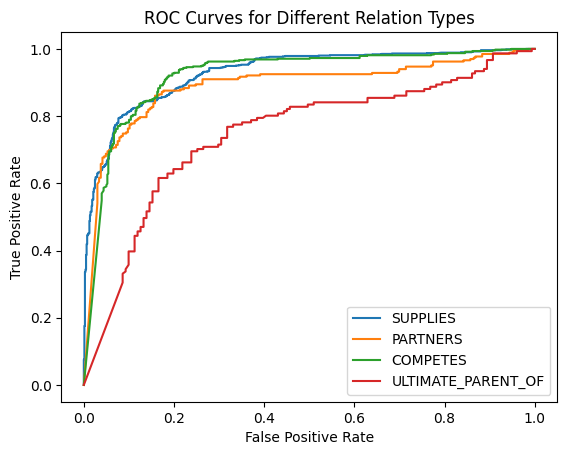

In [ ]:
#VALIDATE
evaluate(val_data,modelRGCN_trained,t=0.5)

AUC for class 1: 0.9450
f1 score for class 1: 0.8806
AUC for class 2: 0.8938
f1 score for class 2: 0.8282
AUC for class 3: 0.9285
f1 score for class 3: 0.8703
AUC for class 4: 0.7682
f1 score for class 4: 0.7370


0.7681570983728784

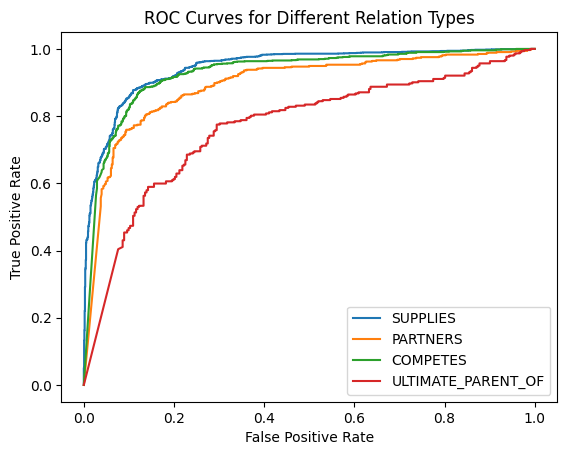

In [ ]:
# TEST
evaluate(test_data,modelRGCN_trained)

In [ ]:
## P treshold tuning
v=np.arange(0.4,0.7,0.05)
for i in v:
    print(f"when t= {i}")
    evaluate(val_data,modelRGCN_trained,t=i)

when t= 0.4
AUC for class 1: 0.9512
Accuracy for class 1: 0.8866
Recall for class 1: 0.8821
Precision for class 1: 0.8902
f1 score for class 1: 0.8861
AUC for class 2: 0.9305
Accuracy for class 2: 0.5000
Recall for class 2: 1.0000
Precision for class 2: 0.5000
f1 score for class 2: 0.6667
AUC for class 3: 0.9370
Accuracy for class 3: 0.5000
Recall for class 3: 1.0000
Precision for class 3: 0.5000
f1 score for class 3: 0.6667
AUC for class 4: 0.8273
Accuracy for class 4: 0.5000
Recall for class 4: 1.0000
Precision for class 4: 0.5000
f1 score for class 4: 0.6667
when t= 0.45
AUC for class 1: 0.9512
Accuracy for class 1: 0.8864
Recall for class 1: 0.8795
Precision for class 1: 0.8919
f1 score for class 1: 0.8856
AUC for class 2: 0.9305
Accuracy for class 2: 0.5000
Recall for class 2: 1.0000
Precision for class 2: 0.5000
f1 score for class 2: 0.6667
AUC for class 3: 0.9370
Accuracy for class 3: 0.5000
Recall for class 3: 1.0000
Precision for class 3: 0.5000
f1 score for class 3: 0.6667
AU

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC for class 2: 0.9305
Accuracy for class 2: 0.5000
Recall for class 2: 0.0000
Precision for class 2: 0.0000
f1 score for class 2: 0.0000
AUC for class 3: 0.9370
Accuracy for class 3: 0.7164
Recall for class 3: 0.4365
Precision for class 3: 0.9917
f1 score for class 3: 0.6062
AUC for class 4: 0.8273
Accuracy for class 4: 0.5302
Recall for class 4: 0.0694
Precision for class 4: 0.8864
f1 score for class 4: 0.1287
when t= 0.6499999999999999
AUC for class 1: 0.9512
Accuracy for class 1: 0.8766
Recall for class 1: 0.8090
Precision for class 1: 0.9356
f1 score for class 1: 0.8677
AUC for class 2: 0.9305
Accuracy for class 2: 0.5000
Recall for class 2: 0.0000
Precision for class 2: 0.0000
f1 score for class 2: 0.0000
AUC for class 3: 0.9370
Accuracy for class 3: 0.6251
Recall for class 3: 0.2521
Precision for class 3: 0.9928
f1 score for class 3: 0.4020
AUC for class 4: 0.8273
Accuracy for class 4: 0.5214
Recall for class 4: 0.0463
Precision for class 4: 0.9286
f1 score for class 4: 0.0881


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


experiment for wd: 0 and channels: [32, 32]
Epoch: 1,Loss: 1.855505108833313
Epoch: 2,Loss: 0.333621621131897
Epoch: 3,Loss: 0.21762175858020782
Epoch: 4,Loss: 0.19558869302272797
Epoch: 5,Loss: 0.1832127422094345
Epoch: 6,Loss: 0.17876379191875458
Epoch: 7,Loss: 0.16766442358493805
Epoch: 8,Loss: 0.16038990020751953
Epoch: 9,Loss: 0.15473614633083344
Epoch: 10,Loss: 0.14823788404464722
AUC for class 1: 0.9274
f1 score for class 1: 0.8756
AUC for class 2: 0.7787
f1 score for class 2: 0.7417
AUC for class 3: 0.9209
f1 score for class 3: 0.8557
AUC for class 4: 0.5388
f1 score for class 4: 0.5489
AUC for class 1: 0.9468
f1 score for class 1: 0.8908
AUC for class 2: 0.7444
f1 score for class 2: 0.7195
AUC for class 3: 0.9121
f1 score for class 3: 0.8417
AUC for class 4: 0.4865
f1 score for class 4: 0.4878
experiment for wd: 0 and channels: [64, 32]
Epoch: 1,Loss: 1.294700264930725
Epoch: 2,Loss: 0.25593674182891846
Epoch: 3,Loss: 0.20873203873634338
Epoch: 4,Loss: 0.19020895659923553
Epoc

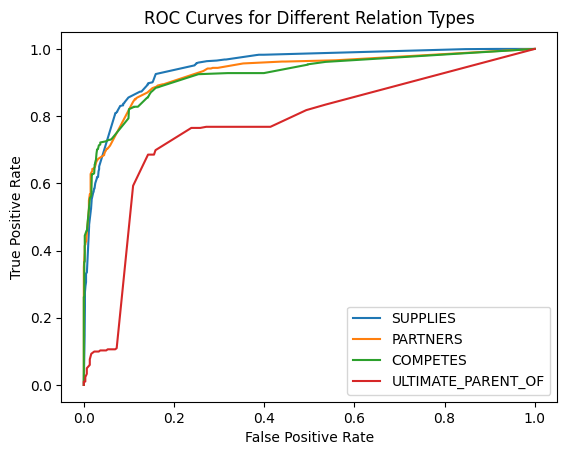

In [ ]:
## TUNING
wd=[0, 1e-3, 5e-3,1e-2]
hid=[[32,32],[64,32],[64,64]]
val_auc=np.empty((5,3))
test_auc=np.empty((5,3))
for i in  wd:
    #c1=0
    for h in hid:
            #c2=0
            modelRGCN = GAE(
              RGCNEncoder(data.num_nodes, hidden_channels=h[0], out_channels=h[1],num_relations=len(edge_types)),
               DistMultDecoder(len(edge_types), hidden_channels=h[1])
            )
            optimizer = torch.optim.Adam(modelRGCN.parameters(), lr=0.01, weight_decay=i) # weight_decay=5*1e-3 optimal for 1 sector, 5e-2 for 2 sector
            modelRGCN.loss=torch.nn.BCEWithLogitsLoss() #pos_weight = torch.ones([1])
            print(f"experiment for wd: {i} and channels: {h}")
            trained=train_batch(modelRGCN,epochs=10)
            evaluate(val_data,trained)
            evaluate(test_data,trained)
            #c2+=1
    #c2+=1
#print(val_auc)
#print(test_auc)



## RGCN-MTES WITH ACTUAL NODE FEATURES

In [ ]:
### MULTI-EDGETYPE SCORES
from torch_geometric.nn import GAE, RGCNConv
from torch.nn import Parameter
class RGCNEncoder(torch.nn.Module):
    def __init__(self, num_nodes, feature_dim,hidden_channels,out_channels,num_relations):
        super().__init__()
        #self.node_emb = Parameter(torch.Tensor(num_nodes, hidden_channels)) ##Initiliaze Learnable embedding vector (paper r-GAT)
        self.conv1 = RGCNConv(feature_dim, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)
        self.reset_parameters()

    def reset_parameters(self):
        #torch.nn.init.xavier_uniform_(self.node_emb)
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self,x, edge_index, edge_type):
        #x = self.node_emb
        x1 = self.conv1(x, edge_index, edge_type).relu_()
        #x = F.dropout(x, p=0.2, training=self.training)
        z = self.conv2(x1, edge_index, edge_type).relu_()
        return z


class DistMultDecoder(torch.nn.Module):
    def __init__(self, num_relations, hidden_channels):
        super().__init__()
        self.rel_emb = Parameter(torch.Tensor(num_relations, hidden_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.rel_emb)

    def forward(self, z, edge_label_index):
        scores={}
        for i in range(len(edge_types)):
                z_src, z_dst = z[edge_label_index[i+1][0]], z[edge_label_index[i+1][1]]
#         out=torch.empty(0)
#         for i in range(len(edge_type)):
#             #score=torch.sum(z_src[i]*rel_emb*z_dst[i], dim=1)
#             out=torch.cat([out,torch.max(torch.sum(z_src[i-1]*rel_emb*z_dst[i-1], dim=1).sigmoid(),dim=0,keepdim=True).indices+1],dim=-1)
#         pred=out#.to(torch.int64)
                scores[i]=torch.sum(z_src*self.rel_emb[i]*z_dst, dim=1)
        return  scores


In [ ]:
modelRGCN = GAE(
    RGCNEncoder(data.num_nodes, feature_dim=data['Company'].x.size(1) ,hidden_channels=64, out_channels=64,num_relations=len(edge_types)),
    DistMultDecoder(len(edge_types), hidden_channels=64)
)
optimizer = torch.optim.Adam(modelRGCN.parameters(), lr=0.01, weight_decay=0.3) # weight_decay=5*1e-3 optimal for 1 sector, 5e-2 for 2 sector
modelRGCN.loss=torch.nn.BCEWithLogitsLoss() #pos_weight = torch.ones([1])

In [ ]:
#Train with mini-batchs
def train_batch(model,epochs):
    model.train()
    for epoch in range(epochs):
        total_examples = total_loss = 0
        #z_train=torch.empty([data.num_nodes, model.encoder.conv1.out_channels])
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            batch_size = train_loader.batch_size
            edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
            labelled_edge_indexes={}
            labelled_edgetype={}
            #out={}
            i=1
            for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,batch[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,batch[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                labelled_edge_indexes[i]=batch[key].edge_label_index
                labelled_edgetype[i]=batch[key].edge_label
                i+=1
            #edge_indexes=edge_indexes.view(-1)
            edgetype=edgetype.view(-1)
            #labelled_edgetype=labelled_edgetype.view(-1)
            #edge_labels=[torch.where(labelled_edgetype == i+1, 1, torch.tensor(0)).to(torch.float)  for i in  range(len(edge_types))]
            #labelled_edge_indexes=labelled_edge_indexes.view(-1)
            z = model.encode(train_data['Company'].x,edge_indexes, edge_type=edgetype)
            #z_train+=z*batch_size

            out = model.decode(z, labelled_edge_indexes)
            #out_all=torch.stack([out[0].sigmoid(), out[1].sigmoid(),out[2].sigmoid(),out[3].sigmoid()])
            loss=float(0)
            for i in  range(len(edge_types)):
                loss += model.loss(out[i], labelled_edgetype[i+1])
            total_examples += batch_size
            total_loss += loss * batch_size
            #loss_final=total_loss/total_examples
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()
        print(f'Epoch: {epoch + 1},Loss: {total_loss/total_examples}')
        #z_trained=z_train/total_examples
    return  model

In [ ]:
trained_RGCN=train_batch(modelRGCN,10)

TypeError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score
#import tensorflow_ranking as tfr
def evaluate(data,model):
    model.eval()
    #y_true, y_pred = [], []
    with torch.no_grad():
        edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
        labelled_edge_indexes={}
        labelled_edgetype={}
            #out={}
        i=1
        for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,data[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,data[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                labelled_edge_indexes[i]=data[key].edge_label_index
                labelled_edgetype[i]=data[key].edge_label
                i+=1
            #edge_indexes=edge_indexes.view(-1)
        edgetype=edgetype.view(-1)
        z = model.encode(data['Company'].x,edge_indexes, edge_type=edgetype)
        scores = model.decode(z, labelled_edge_indexes)
        #scores_all=torch.stack([scores[0].sigmoid(), scores[1].sigmoid(),scores[2].sigmoid(),scores[3].sigmoid()])
    for i in  range(len(edge_types)):
            auc = roc_auc_score(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy())
            acc = accuracy_score(labelled_edgetype[i+1].numpy(), [1 if p >= 0.5 else 0 for p in scores[i].sigmoid().numpy()])
            prec = precision_score(labelled_edgetype[i+1].numpy(), [1 if p >= 0.5 else 0 for p in scores[i].sigmoid().numpy()])
            #hit2=top_k_accuracy_score(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy(), k=2)
            #hits_at_10 = tfr.keras.metrics.HitsMetric(topn=10)
            #hits_at_10(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy()).numpy()
            print(f"AUC for class {i+1}: {auc:.4f}")
            print(f"Accuracy for class {i+1}: {acc:.4f}")
            #print(f"Precision for class {i+1}: {prec:.4f}")
            #print(f"top2 for class {i+1}: {hit2:.4f}")
            #print(f"hit10 for class {i+1}: {hits_at_10:.4f}")
            #mat=confusion_matrix(labelled_edgetype[i+1].numpy(), [1 if p >= 0.5 else 0 for p in scores[i].sigmoid().numpy()])
            #disp = ConfusionMatrixDisplay(confusion_matrix=mat,display_labels=labelled_edgetype[i+1].unique())
            #disp.plot()
    return auc


In [ ]:
##VALIDATION
evaluate(val_data,modelRGCN)

AUC for class 1: 0.9309
Accuracy for class 1: 0.5509
AUC for class 2: 0.8785
Accuracy for class 2: 0.5018
AUC for class 3: 0.0697
Accuracy for class 3: 0.2336
AUC for class 4: 0.7564
Accuracy for class 4: 0.5030


0.7563642644557823

In [ ]:
#TEST
evaluate(test_data,modelRGCN)

AUC for class 1: 0.9236
Accuracy for class 1: 0.5583
AUC for class 2: 0.8995
Accuracy for class 2: 0.5000
AUC for class 3: 0.0721
Accuracy for class 3: 0.2532
AUC for class 4: 0.7675
Accuracy for class 4: 0.5037


0.7674596531320862

In [ ]:
## TUNING
wd=[0, 0.1,0.2,0.3]
hid=[[64,32],[64,64]]
val_auc=np.empty((5,3))
test_auc=np.empty((5,3))
#c1=0
for i in  wd:
    #c2=0
    for h in hid:

            modelRGCN = GAE(
              RGCNEncoder(data.num_nodes, feature_dim=data['Company'].x.size(1) ,hidden_channels=h[0], out_channels=h[1],num_relations=len(edge_types)),
               DistMultDecoder(len(edge_types), hidden_channels=h[1])
            )
            optimizer = torch.optim.Adam(modelRGCN.parameters(), lr=0.01, weight_decay=i) # weight_decay=5*1e-3 optimal for 1 sector, 5e-2 for 2 sector
            modelRGCN.loss=torch.nn.BCEWithLogitsLoss() #pos_weight = torch.ones([1])
            print(f"experiment for wd: {i} and channels: {h}")
            train_batch(modelRGCN,epochs=10)
            evaluate(val_data,modelRGCN)
            evaluate(test_data,modelRGCN)
            #c2+=1
    #c2+=1
#print(val_auc)
#print(test_auc)


experiment for wd: 0 and channels: [64, 32]
Epoch: 1,Loss: 473646.625


KeyboardInterrupt: ignored

## RGAT-MTES WITH LEARNABLE SELF EMBEDDING

In [ ]:
### SELF NODE EMBEDDING
from torch_geometric.nn import RGATConv, GAE
import torch.nn.functional as F
from torch.nn import Parameter

class RGAT(torch.nn.Module):
    def __init__(self, num_nodes, hidden_channels, out_channels,
                 num_relations,dim, edge_dim=None ,attention_mechanism='within-relation', attention_mode='multiplicative-self-attention',
                 heads=1, concat=False):
        super().__init__()
        self.node_emb = Parameter(torch.Tensor(num_nodes, hidden_channels)) ##Initiliaze Learnable embedding vector (paper r-GAT)
        self.conv1 = RGATConv(hidden_channels, hidden_channels, num_relations,attention_mode= attention_mode,dim=dim,edge_dim=edge_dim,heads=heads,concat=concat )
        self.conv2 = RGATConv(dim*hidden_channels, out_channels, num_relations,attention_mode=attention_mode,dim=dim,edge_dim =edge_dim,heads=heads,concat=concat)
        #self.lin = torch.nn.Linear(-1, out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.node_emb)
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self,  edge_index, edge_type, edge_attr=None):
        x = self.node_emb
        x = self.conv1(x, edge_index, edge_type, edge_attr).relu()
        z = self.conv2(x, edge_index, edge_type, edge_attr)#.relu()
        #x = self.lin(x)
        return z  #F.log_softmax(x, dim=-1)


class DistMultDecoder(torch.nn.Module):
    def __init__(self, num_relations, hidden_channels):
        super().__init__()
        self.rel_emb = Parameter(torch.Tensor(num_relations, hidden_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.rel_emb)

    def forward(self, z, edge_label_index):
        scores={}
        for i in range(len(edge_types)):
                z_src, z_dst = z[edge_label_index[i+1][0]], z[edge_label_index[i+1][1]]
#         out=torch.empty(0)
#         for i in range(len(edge_type)):
#             #score=torch.sum(z_src[i]*rel_emb*z_dst[i], dim=1)
#             out=torch.cat([out,torch.max(torch.sum(z_src[i-1]*rel_emb*z_dst[i-1], dim=1).sigmoid(),dim=0,keepdim=True).indices+1],dim=-1)
#         pred=out#.to(torch.int64)
                scores[i]=torch.sum(z_src*self.rel_emb[i]*z_dst, dim=1)
        return  scores


In [ ]:
modelRGAT = GAE(
    RGAT(num_nodes=data.num_nodes,hidden_channels=64, out_channels=64, num_relations=len(edge_types),
         dim=1,attention_mechanism='within-relation',attention_mode='multiplicative-self-attention',heads=1), #edge_dim=data['SUPPLIES'].edge_attr.size(-1)
    DistMultDecoder(len(edge_types), hidden_channels=64)).to(device)
optimizer = torch.optim.Adam(modelRGAT.parameters(), lr=0.01, weight_decay=0.01) # weight_decay=0.005 foptima for 1 sector(self)
modelRGAT.loss=torch.nn.BCEWithLogitsLoss()

In [ ]:
#Train with mini-batchs SELF NODE
def train_batch(model,epochs):
    model.train()
    for epoch in range(epochs):
        total_examples = total_loss = 0
        #z_train=torch.empty([data.num_nodes, model.encoder.conv1.out_channels])
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            batch_size = train_loader.batch_size
            edgeattr,edgetype, edge_indexes=torch.empty(1,0),torch.empty(1,0),torch.empty(2,0)
            labelled_edge_indexes={}
            labelled_edgetype={}
            #out={}
            i=1
            for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,batch[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,batch[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                labelled_edge_indexes[i]=batch[key].edge_label_index
                labelled_edgetype[i]=batch[key].edge_label
                i+=1
            #edge_indexes=edge_indexes.view(-1)
            edgetype=edgetype.view(-1)
            #edgeattr=torch.cat([batch['SUPPLIES'].edge_attr,torch.full((1,edgetype.size(0)-batch['SUPPLIES'].edge_attr.size(0)),0).view(-1)],dim=-1).to(torch.int64)
            #labelled_edgetype=labelled_edgetype.view(-1)
            #edge_labels=[torch.where(labelled_edgetype == i+1, 1, torch.tensor(0)).to(torch.float)  for i in  range(len(edge_types))]
            #labelled_edge_indexes=labelled_edge_indexes.view(-1)
            z = model.encode(edge_indexes, edge_type=edgetype) #edge_dim=data['SUPPLIES'].edge_attr.size(-1)
            #z_train+=z*batch_size

            out = model.decode(z, labelled_edge_indexes)
            #out_all=torch.stack([out[0].sigmoid(), out[1].sigmoid(),out[2].sigmoid(),out[3].sigmoid()])
            loss=float(0)
            for i in  range(len(edge_types)):
                loss += model.loss(out[i], labelled_edgetype[i+1])
            total_examples += batch_size
            total_loss += loss * batch_size
            #loss_final=total_loss/total_examples
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()
        print(f'Epoch: {epoch + 1},Loss: {total_loss/total_examples}')
        #z_trained=z_train/total_examples
    return  model

In [ ]:
trained_RGAT=train_batch(modelRGAT,epochs=10)

Epoch: 1,Loss: 2.764150381088257
Epoch: 2,Loss: 2.5930912494659424
Epoch: 3,Loss: 2.4142510890960693
Epoch: 4,Loss: 2.3257272243499756
Epoch: 5,Loss: 2.3162996768951416
Epoch: 6,Loss: 2.320303440093994
Epoch: 7,Loss: 2.3166422843933105
Epoch: 8,Loss: 2.316108465194702
Epoch: 9,Loss: 2.314685821533203
Epoch: 10,Loss: 2.3162736892700195


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score,confusion_matrix,ConfusionMatrixDisplay

def evaluate(data,model,t=0.5):
    model.eval()
    #y_true, y_pred = [], []
    with torch.no_grad():
        edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
        labelled_edge_indexes={}
        labelled_edgetype={}
            #out={}
        i=1
        for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,data[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,data[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                labelled_edge_indexes[i]=data[key].edge_label_index
                labelled_edgetype[i]=data[key].edge_label
                i+=1
            #edge_indexes=edge_indexes.view(-1)
        edgetype=edgetype.view(-1)
        z = model.encode(edge_indexes, edge_type=edgetype,edge_attr=None)
        scores = model.decode(z, labelled_edge_indexes)
        #scores_all=torch.stack([scores[0].sigmoid(), scores[1].sigmoid(),scores[2].sigmoid(),scores[3].sigmoid()])
    for i in  range(len(edge_types)):
            auc = roc_auc_score(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy())
            acc = accuracy_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            prec = precision_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            f1=f1_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            print(f"AUC for class {i+1}: {auc:.4f}")
            print(f"accuracy for class {i+1}: {acc:.4f}")
            print(f"F1 score for class {i+1}: {f1:.4f}")
            #print(f"precision for class {i+1}: {prec:.4f}")
            #mat=confusion_matrix(labelled_edgetype[i+1].numpy(), [1 if p >= 0.5 else 0 for p in scores[i].sigmoid().numpy()])
            #disp = ConfusionMatrixDisplay(confusion_matrix=mat,display_labels=labelled_edgetype[i+1].unique())
            #disp.plot()
    return z


In [ ]:
# VALIDATE
evaluate(val_data,trained_RGAT)

AUC for class 1: 0.9196
accuracy for class 1: 0.8585
F1 score for class 1: 0.8698
AUC for class 2: 0.9041
accuracy for class 2: 0.5150
F1 score for class 2: 0.6718
AUC for class 3: 0.6357
accuracy for class 3: 0.7599
F1 score for class 3: 0.7901
AUC for class 4: 0.7055
accuracy for class 4: 0.6954
F1 score for class 4: 0.7386


tensor([[ 5.5368e-07,  3.4805e-03, -2.1235e-06,  ..., -1.0024e-06,
          1.1970e-06,  8.1438e-01],
        [-1.6099e-05,  2.8444e-03, -7.5572e-08,  ...,  2.4447e-05,
          4.0390e-06,  2.1891e+00],
        [-3.5084e-07,  3.5113e-03, -2.5020e-06,  ..., -1.7870e-07,
          3.4829e-07,  2.7890e-01],
        ...,
        [-3.5084e-07,  3.5113e-03, -2.5020e-06,  ..., -1.7870e-07,
          3.4829e-07,  2.7890e-01],
        [ 9.3908e-07,  3.5207e-03, -1.5113e-06,  ...,  2.0084e-06,
          9.5204e-07,  1.2876e+00],
        [-3.5084e-07,  3.5113e-03, -2.5020e-06,  ..., -1.7870e-07,
          3.4829e-07,  2.7890e-01]])

In [ ]:
#TEST
evaluate(test_data,trained_RGAT) #trained_RGAT

AUC for class 1: 0.9089
accuracy for class 1: 0.8495
F1 score for class 1: 0.8610
AUC for class 2: 0.8910
accuracy for class 2: 0.5216
F1 score for class 2: 0.6743
AUC for class 3: 0.6026
accuracy for class 3: 0.7346
F1 score for class 3: 0.7694
AUC for class 4: 0.7002
accuracy for class 4: 0.6474
F1 score for class 4: 0.7078


tensor([[ 5.5368e-07,  3.4805e-03, -2.1235e-06,  ..., -1.0024e-06,
          1.1970e-06,  8.1438e-01],
        [-1.6099e-05,  2.8444e-03, -7.5572e-08,  ...,  2.4447e-05,
          4.0390e-06,  2.1891e+00],
        [-3.5084e-07,  3.5113e-03, -2.5020e-06,  ..., -1.7870e-07,
          3.4829e-07,  2.7890e-01],
        ...,
        [-3.5084e-07,  3.5113e-03, -2.5020e-06,  ..., -1.7870e-07,
          3.4829e-07,  2.7890e-01],
        [ 9.3908e-07,  3.5207e-03, -1.5113e-06,  ...,  2.0084e-06,
          9.5204e-07,  1.2876e+00],
        [-3.5084e-07,  3.5113e-03, -2.5020e-06,  ..., -1.7870e-07,
          3.4829e-07,  2.7890e-01]])

In [ ]:
## TUNING
wd=[1e-3, 5e-3, 1e-2]
hid=[[32,32],[64,32],[64,64]]
mode=['multiplicative-self-attention','additive-self-attention']
mec=['within-relation','across-relation']
val_auc=np.empty((5,3))
test_auc=np.empty((5,3))
for h in hid:
    #c1=0
    for i in  wd:
            #c2=0
            modelRGAT = GAE(
                RGAT(num_nodes=data.num_nodes,hidden_channels=h[0], out_channels=h[1], num_relations=len(edge_types),dim=1,
                     attention_mode='multiplicative-self-attention',attention_mechanism='within-relation',heads=1),
                DistMultDecoder(len(edge_types), hidden_channels=h[1])
                ).to(device)
            optimizer = torch.optim.Adam(modelRGAT.parameters(), lr=0.01, weight_decay=i)
            modelRGAT.loss=torch.nn.BCEWithLogitsLoss()
            print(f"experiment for wd:{i} and channels:{h}")
            trained=train_batch(modelRGAT,epochs=7)
            evaluate(val_data,trained)
            evaluate(test_data,trained)
            #c2+=1
    #c2+=1
#print(val_auc)
#print(test_auc)


experiment for wd:0.001 and channels:[32, 32]
Epoch: 1,Loss: 2.7249536514282227
Epoch: 2,Loss: 2.468766927719116
Epoch: 3,Loss: 2.3211357593536377
Epoch: 4,Loss: 2.3099470138549805
Epoch: 5,Loss: 2.306981086730957
Epoch: 6,Loss: 2.306887626647949
Epoch: 7,Loss: 2.3048343658447266
AUC for class 1: 0.9205
accuracy for class 1: 0.8603
F1 score for class 1: 0.8725
AUC for class 2: 0.9098
accuracy for class 2: 0.7726
F1 score for class 2: 0.8033
AUC for class 3: 0.6259
accuracy for class 3: 0.4958
F1 score for class 3: 0.4174
AUC for class 4: 0.6298
accuracy for class 4: 0.6490
F1 score for class 4: 0.6687
AUC for class 1: 0.9113
accuracy for class 1: 0.8511
F1 score for class 1: 0.8638
AUC for class 2: 0.8932
accuracy for class 2: 0.7679
F1 score for class 2: 0.8010
AUC for class 3: 0.5952
accuracy for class 3: 0.4797
F1 score for class 3: 0.4109
AUC for class 4: 0.6193
accuracy for class 4: 0.6589
F1 score for class 4: 0.6888
experiment for wd:0.005 and channels:[32, 32]
Epoch: 1,Loss: 2.

## RGAT-MTES WITH ACTUAL NODE FEATURES

In [ ]:
from torch_geometric.nn import RGATConv, GAE
import torch.nn.functional as F
from torch.nn import Parameter

class RGAT(torch.nn.Module):
    def __init__(self, feature_dim, hidden_channels, out_channels,
                 num_relations,dim, edge_dim=None ,attention_mechanism='within-relation', attention_mode='multiplicative-self-attention',
                 heads=1, concat=False):
        super().__init__()
        self.conv1 = RGATConv(feature_dim, hidden_channels, num_relations,attention_mode= attention_mode,dim=dim)
        self.conv2 = RGATConv(dim*hidden_channels, out_channels, num_relations,attention_mode=attention_mode,dim=dim )
        #self.lin = torch.nn.Linear(-1, out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index, edge_type, edge_attr):
        #x = self.node_emb()
        x = self.conv1(x, edge_index, edge_type, edge_attr).relu()
        z = self.conv2(x, edge_index, edge_type, edge_attr).relu()
        #x = self.lin(x)
        return z  #F.log_softmax(x, dim=-1)


class DistMultDecoder(torch.nn.Module):
    def __init__(self, num_relations, hidden_channels):
        super().__init__()
        self.rel_emb = Parameter(torch.Tensor(num_relations, hidden_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.rel_emb)

    def forward(self, z, edge_label_index):
        scores={}
        for i in range(len(edge_types)):
                z_src, z_dst = z[edge_label_index[i+1][0]], z[edge_label_index[i+1][1]]
#         out=torch.empty(0)
#         for i in range(len(edge_type)):
#             #score=torch.sum(z_src[i]*rel_emb*z_dst[i], dim=1)
#             out=torch.cat([out,torch.max(torch.sum(z_src[i-1]*rel_emb*z_dst[i-1], dim=1).sigmoid(),dim=0,keepdim=True).indices+1],dim=-1)
#         pred=out#.to(torch.int64)
                scores[i]=torch.sum(z_src*self.rel_emb[i]*z_dst, dim=1)
        return  scores


In [ ]:
modelRGAT = GAE(
    RGAT(feature_dim=data['Company'].x.size(1),hidden_channels=64, out_channels=32,num_relations=len(edge_types),dim=1),
    DistMultDecoder(len(edge_types), hidden_channels=32)).to(device)
optimizer = torch.optim.Adam(modelRGAT.parameters(), lr=0.01, weight_decay=0.01) # weight_decay=0.01 optima for 1 sector
modelRGAT.loss=torch.nn.BCEWithLogitsLoss()

In [ ]:
from torch_geometric.profile import count_parameters
count_parameters(modelRGAT)


517504

In [ ]:
#Train with mini-batchs
def train_batch(model,epochs):
    model.train()
    for epoch in range(epochs):
        total_examples = total_loss = 0
        #z_train=torch.empty([data.num_nodes, model.encoder.conv1.out_channels])
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            batch_size = train_loader.batch_size
            edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
            labelled_edge_indexes={}
            labelled_edgetype={}
            #out={}
            i=1
            for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,batch[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,batch[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                labelled_edge_indexes[i]=batch[key].edge_label_index
                labelled_edgetype[i]=batch[key].edge_label
                i+=1
            #edge_indexes=edge_indexes.view(-1)
            edgetype=edgetype.view(-1)
            #labelled_edgetype=labelled_edgetype.view(-1)
            #edge_labels=[torch.where(labelled_edgetype == i+1, 1, torch.tensor(0)).to(torch.float)  for i in  range(len(edge_types))]
            #labelled_edge_indexes=labelled_edge_indexes.view(-1)
            z = model.encode(data['Company'].x,edge_indexes, edge_type=edgetype,edge_attr=None)
            #z_train+=z*batch_size

            out = model.decode(z, labelled_edge_indexes)
            #out_all=torch.stack([out[0].sigmoid(), out[1].sigmoid(),out[2].sigmoid(),out[3].sigmoid()])
            loss=float(0)
            for i in  range(len(edge_types)):
                loss += model.loss(out[i], labelled_edgetype[i+1])
            total_examples += batch_size
            total_loss += loss * batch_size
            #loss_final=total_loss/total_examples
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()
        print(f'Epoch: {epoch + 1},Loss: {total_loss/total_examples}')
        #z_trained=z_train/total_examples
    return  model

In [ ]:
trained_RGAT=train_batch(modelRGAT,epochs=5)

Epoch: 1,Loss: 253736.640625


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score,confusion_matrix,ConfusionMatrixDisplay

def evaluate(data,model,t=0.5):
    model.eval()
    #y_true, y_pred = [], []
    with torch.no_grad():
        edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
        labelled_edge_indexes={}
        labelled_edgetype={}
            #out={}
        i=1
        for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,data[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,data[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                labelled_edge_indexes[i]=data[key].edge_label_index
                labelled_edgetype[i]=data[key].edge_label
                i+=1
            #edge_indexes=edge_indexes.view(-1)
        edgetype=edgetype.view(-1)
        z = model.encode(data['Company'].x,edge_indexes, edge_type=edgetype,edge_attr=None)
        scores = model.decode(z, labelled_edge_indexes)
        #scores_all=torch.stack([scores[0].sigmoid(), scores[1].sigmoid(),scores[2].sigmoid(),scores[3].sigmoid()])
    for i in  range(len(edge_types)):
            auc = roc_auc_score(labelled_edgetype[i+1].numpy(), scores[i].sigmoid().numpy())
            #acc = accuracy_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            #prec = precision_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            f1=f1_score(labelled_edgetype[i+1].numpy(), [1 if p >= t else 0 for p in scores[i].sigmoid().numpy()])
            print(f"AUC for class {i+1}: {auc:.4f}")
            #print(f"accuracy for class {i+1}: {acc:.4f}")
            print(f"F1 score for class {i+1}: {f1:.4f}")
            #print(f"precision for class {i+1}: {prec:.4f}")
            #mat=confusion_matrix(labelled_edgetype[i+1].numpy(), [1 if p >= 0.5 else 0 for p in scores[i].sigmoid().numpy()])
            #disp = ConfusionMatrixDisplay(confusion_matrix=mat,display_labels=labelled_edgetype[i+1].unique())
            #disp.plot()
    return z

In [ ]:
evaluate(val_data,modelRGAT)

AUC for class 1: 0.8648
F1 score for class 1: 0.6693
AUC for class 2: 0.1278
F1 score for class 2: 0.0070
AUC for class 3: 0.1147
F1 score for class 3: 0.0084
AUC for class 4: 0.3438
F1 score for class 4: 0.0000


tensor([[0.0000, 0.0000, 0.0083,  ..., 0.0000, 0.0882, 0.0021],
        [0.0000, 0.0000, 0.0083,  ..., 0.0000, 0.0882, 0.0021],
        [0.0000, 0.0000, 0.0083,  ..., 0.0000, 0.0882, 0.0021],
        ...,
        [0.0000, 0.0000, 0.0083,  ..., 0.0000, 0.0882, 0.0021],
        [0.0000, 0.0000, 0.0083,  ..., 0.0000, 0.0882, 0.0021],
        [0.0000, 0.0000, 0.0083,  ..., 0.0000, 0.0882, 0.0021]])

In [ ]:
## TUNING
wd=[0, 0.1,0.2,0.3]
hid=[[64,32],[64,64]]
mode=['multiplicative-self-attention','additive-self-attention']
mec=['within-relation','across-relation']
val_auc=np.empty((5,3))
test_auc=np.empty((5,3))
for h in hid:
    #c1=0
    for i in  wd:
            #c2=0
            modelRGAT = GAE(
                 RGAT(feature_dim=data['Company'].x.size(1),hidden_channels=h[0], out_channels=h[1],num_relations=len(edge_types),dim=1),
                 DistMultDecoder(len(edge_types), hidden_channels=h[1])).to(device)
            optimizer = torch.optim.Adam(modelRGAT.parameters(), lr=0.01, weight_decay=i)
            modelRGAT.loss=torch.nn.BCEWithLogitsLoss()
            print(f"experiment for wd:{i} and channels:{h}")
            trained=train_batch(modelRGAT,epochs=7)
            evaluate(val_data,trained)
            evaluate(test_data,trained)
            #c2+=1
    #c2+=1
#print(val_auc)
#print(test_auc)


experiment for wd:0 and channels:[64, 32]


## Batch evaluation for entire network (if needed)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score,roc_curve ,RocCurveDisplay

def evaluate_batch(loader,model):
    model.eval()
    #y_true, y_pred = [], []
    y_true, y_pred=torch.empty(4,0),torch.empty(4,0)
    for batch in loader:
        with torch.no_grad():
            batch = batch.to(device)
            edgetype, edge_indexes, labelled_edge_indexes, labelled_edgetype=torch.empty(1,0),torch.empty(2,0),torch.empty(2,0),torch.empty(0)
            #labelled_edge=torch.empty(0)
            i=1
            for key in edge_types:
                #edge_indexes=torch.cat([edge_indexes,batch[key].edge_index],dim=-1).to(torch.int64)
                #edgetype=torch.cat([edgetype,torch.full((1,batch[key].edge_index.size(1)),i)],dim=-1).to(torch.int64)
                labelled_edge_indexes=torch.cat([labelled_edge_indexes,batch[key].edge_label_index],dim=-1).to(torch.int64)
                labelled_edgetype=torch.cat([labelled_edgetype,batch[key].edge_label*i],dim=-1).to(torch.int64)
                #labelled_edge=torch.cat([labelled_edge,batch[key].edge_label],dim=-1)
                i+=1
            #edge_indexes=edge_indexes.view(-1)
            #edgetype=edgetype.view(-1)
            #labelled_edgetype=labelled_edgetype.view(-1)
            edge_labels=[torch.where(labelled_edgetype == i+1, 1, torch.tensor(0)).to(torch.float)  for i in  range(len(edge_types))]
            labels=torch.stack([edge_labels[0], edge_labels[1],edge_labels[2], edge_labels[3]])
            z = model.encode(edge_indexes, edge_type=edgetype)
            scores = model.decode(z, labelled_edge_indexes)
            scores_all=torch.stack([scores[0].sigmoid(), scores[1].sigmoid(),scores[2].sigmoid(),scores[3].sigmoid()])
            #scores_max=torch.max(scores_all, dim=0)
            #pred=torch.argmax(scores_all, dim=0)+1
            y_pred=torch.cat([y_pred,scores_all],dim=1)
            y_true =torch.cat([y_true,labels],dim=1)
    for i in  range(len(edge_types)):
            auc = roc_auc_score(y_true[i].numpy(), y_pred[i].numpy())
            acc = accuracy_score(y_true[i].numpy(), [1 if p >= 0.5 else 0 for p in y_pred[i].numpy()])
            RocCurveDisplay.from_predictions(y_true[i].numpy(), y_pred[i].numpy())
            print(f"Validation AUC for class {i+1}: {auc:.4f}")
            print(f"Validation accuracy for class {i+1}: {acc:.4f}")
    return auc, acc




## APPLICATION TO A SUBGRAPH

In [ ]:
from torch_geometric.utils import k_hop_subgraph
import random
r=random.randint(1, data['Company'].x.size(0))
n=25

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score
from torch_geometric.utils import k_hop_subgraph
import random
from itertools import combinations
#import tensorflow_ranking as tfr
def predict(data,model,hop):
    model.eval()
    #y_true, y_pred = [], []
    with torch.no_grad():
        edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
        i=1
        for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,data[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,data[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                i+=1
            #edge_indexes=edge_indexes.view(-1)
        edgetype=edgetype.view(-1)
        subset, edge_index, mapping, edge_mask = k_hop_subgraph(r, hop, edge_indexes, relabel_nodes=False)
        combinations_2 = list(combinations(subset, 2))
        comb=torch.tensor(combinations_2)
        c={}
        for i in  range(len(edge_types)):
          c[i+1]=comb.T
        #z = model.encode(edge_indexes, edge_type=edgetype)
        z = model.encode(edge_index, edge_type=edgetype[edge_mask])
        scores = model.decode(z, c)
        pred={}
    for i in  range(len(edge_types)):
            pred[i+1] = scores[i].sigmoid()
            #print(f"Probability for class {i+1}: {pred[i+1]}")
    return pred


In [ ]:
prob=predict(data,modelRGCN_trained,hop=2)

In [ ]:
prob

{1: tensor([0.0118, 0.0044, 0.0314, 0.0055, 0.2844, 0.0090, 0.0967, 0.0118, 0.4792,
         0.0232, 0.0044, 0.2443, 0.0314, 0.7523, 0.2844]),
 2: tensor([0.4945, 0.4894, 0.5004, 0.4939, 0.5035, 0.4890, 0.5063, 0.4945, 0.5092,
         0.4950, 0.4894, 0.5002, 0.5004, 0.5199, 0.5035]),
 3: tensor([0.4936, 0.4894, 0.4988, 0.4967, 0.5005, 0.4852, 0.5000, 0.4936, 0.5032,
         0.4911, 0.4894, 0.4962, 0.4988, 0.5116, 0.5005]),
 4: tensor([0.5040, 0.4882, 0.5223, 0.4917, 0.5270, 0.4987, 0.5542, 0.5040, 0.5536,
         0.5147, 0.4882, 0.5210, 0.5223, 0.5920, 0.5270])}

In [ ]:
prob[1][prob[1]>0.55].size()

torch.Size([1])

In [ ]:
edgetype, edge_indexes=torch.empty(1,0),torch.empty(2,0)
i=1
for key in edge_types:
                edge_indexes=torch.cat([edge_indexes,data_und[key].edge_index],dim=-1).to(torch.int64)
                edgetype=torch.cat([edgetype,torch.full((1,data_und[key].edge_index.size(1)),i-1)],dim=-1).to(torch.int64)
                i+=1
            #edge_indexes=edge_indexes.view(-1)
edgetype=edgetype.view(-1)
subset, edge_index, mapping, edge_mask = k_hop_subgraph(r, 2, edge_indexes, relabel_nodes=False)
combinations_2 = list(combinations(subset, 2))
comb=torch.tensor(combinations_2)

In [ ]:
subset

tensor([ 9901, 17720, 23130, 26254, 26690, 34376])

In [ ]:
edge_index

tensor([[ 9901, 17720, 26254, 26690, 26254, 17720, 26690, 34376],
        [34376, 34376, 34376, 34376, 17720, 26254, 26254, 23130]])

In [ ]:
edgetype[edge_mask]

tensor([0, 0, 0, 0, 1, 1, 2, 3])

In [ ]:
comb

tensor([[ 9901, 17720],
        [ 9901, 23130],
        [ 9901, 26254],
        [ 9901, 26690],
        [ 9901, 34376],
        [17720, 23130],
        [17720, 26254],
        [17720, 26690],
        [17720, 34376],
        [23130, 26254],
        [23130, 26690],
        [23130, 34376],
        [26254, 26690],
        [26254, 34376],
        [26690, 34376]])